In [1]:
import numpy as np
import pandas as pd
import transformers
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import random
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import mean_absolute_error, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_cosine_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

In [4]:
data = np.load('data/forex/all_forex_data_ffill_300.npy', allow_pickle=True)

In [17]:
np.save('data_clustered', data_clustered)

In [18]:
data_clustered.shape

(815635, 299)

In [5]:
data_clustered = np.load('data_clustered.npy')

In [6]:
max_size = 299

In [7]:
class SongLyrics(Dataset):  
    def __init__(self, context):
        self.context = context
        
    def __len__(self):
        return len(self.context)

    def __getitem__(self, item):
        x = torch.tensor(self.context[item][-max_size:]).long()
        return x
    
dataset = SongLyrics(data_clustered)  

In [8]:
np.array(dataset.context).shape, dataset.__getitem__(1000).shape

((815635, 299), torch.Size([299]))

In [9]:
dataset.__getitem__(0)

tensor([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        49, 91,  8, 84, 81, 84, 86, 49, 81, 88, 11, 11, 13, 13, 87, 49, 49, 11,
        88, 16, 81, 13, 11, 84, 49, 16, 49, 49, 16, 49, 11, 49, 81, 49, 13, 49,
        13, 13, 49, 89, 16, 13, 11, 86, 11, 81, 86, 16, 81, 84, 11, 86, 81, 11,
        84, 84, 81, 81, 11, 49, 81, 49, 87, 84, 81, 84, 11, 84, 84, 81, 49, 49,
        86,  9, 49, 86, 49, 81, 49, 88, 13, 81, 13, 88, 49, 84, 49, 11, 86, 13,
        81, 81, 84, 81, 81, 86, 16, 16, 16, 49, 49, 81, 89, 81, 88, 13, 13, 11,
        16, 16, 81, 13, 81, 49, 84, 13, 81, 11, 86, 49, 13, 49, 81, 13, 81, 81,
        13, 81, 11, 81, 11, 81, 81, 16, 84, 84, 81, 49, 16, 49, 49, 81, 84, 84,
        84, 84, 11, 84, 16, 86, 13, 16, 81, 16, 86, 84, 81, 13, 10, 16, 49, 16,
        49, 49, 13, 16, 81, 49, 81, 16, 16, 81, 13, 81, 49, 16, 81, 13, 49, 81,
        81, 49, 49, 86, 49, 16, 16, 13, 16, 11, 49, 84, 11, 11, 49, 86, 81, 16,
        16, 11, 81, 81, 13, 16, 49, 49, 

In [11]:
clusters[49]

0.0

In [27]:
import gc
gc.collect()
del model
del input_tensor
del outputs

In [28]:
torch.cuda.empty_cache()

In [7]:
vocab_size = len(clusters)
# bos_token_id=vocab_size-4
# eos_token_id=vocab_size-3
# pad_token_id=vocab_size-2
# unk_token_id=vocab_size-1
    
config = transformers.GPT2Config(
    vocab_size=vocab_size,
#     bos_token_id=bos_token_id,
#     eos_token_id=eos_token_id,
#     pad_token_id=pad_token_id,
#     unk_token_id=unk_token_id,
    bos_token_id=None,
    eos_token_id=None,
    pad_token_id=None,
    unk_token_id=None,
    n_positions=max_size,
    n_ctx=max_size,
    n_embd=12*64,
    num_labels=vocab_size,
    resid_pdrop=0,
    embd_pdrop=0,
    attn_pdrop=0,
)
model = transformers.GPT2LMHeadModel(config).cuda()
model.train()

KeyboardInterrupt: 

In [11]:
vocab_size = 50257
    
config = transformers.GPT2Config(
    vocab_size=vocab_size,
    n_positions=512*2,
    n_ctx=512*2,
    n_embd=12*64*8,
    num_labels=vocab_size
)
model = transformers.GPT2LMHeadModel(config)

KeyboardInterrupt: 

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)/1000000

In [ ]:
get_n_params(model)/1000000

In [ ]:
get_n_params(model)/1000000

In [12]:
get_n_params(model), np.log(5), np.log(data_clustered.size/get_n_params(model)), data_clustered.size/get_n_params(model)

(85361664, 1.6094379124341003, 1.0497581446691984, 2.8569600634776755)

In [9]:
epochs=1
warmup_steps=2000//(512/64)
# warmup_steps = 100
lr=0.000025
output_dir="./runs"
output_prefix="first"
save_model_on_epoch=True
time_steps = 30
    
device=torch.device("cuda")

batch_size_loader=44
batch_size = 512//batch_size_loader
train_dataloader = DataLoader(dataset, batch_size=batch_size_loader, shuffle=True)
loss=0
accumulating_batch_count = 0
input_tensor = None


optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0)
scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs*train_dataloader.__len__()//batch_size
)


for epoch in range(epochs):

    print(f"Training epoch {epoch}")
        
    pbar = tqdm(enumerate(train_dataloader), total=train_dataloader.__len__())
    acc = []
    acc_sign = []
    mae = []
    samples = np.empty((0, 30))
    input_tensors = torch.empty((0, max_size), dtype=torch.long).cuda()
    for idx, input_tensor in pbar:
        input_tensor = input_tensor.to(device)
        
        outputs = model(input_tensor, labels=input_tensor)
        loss = outputs[0]
        loss.backward()
        
        inp = input_tensor.cpu().detach().numpy()
        logits = outputs['logits'].argmax(axis=2).cpu().detach().numpy()
        
        acc.append((logits == inp).sum()/logits.size)
        acc_sign.append((np.sign(logits-len(clusters)//2) == np.sign(inp-len(clusters)//2)).sum()/logits.size)
        mae.append(mean_absolute_error(inp, logits)/len(clusters))

        if (accumulating_batch_count % batch_size) == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            model.zero_grad()
            
        accumulating_batch_count += 1
        
        input_tensor = None
        pbar.set_postfix(loss=loss.cpu().detach().numpy(), ACC=acc[-1], ACC_sign=acc_sign[-1], a_mae=mae[-1],
                         lr=scheduler.get_last_lr()[0])
        
    if save_model_on_epoch:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
        )
        
    print(f"Loss: {loss}, ACC: {np.mean(acc)}, ACC_sign: {np.mean(acc_sign)}, MAE: {np.mean(mae)}")
    print()

  0%|                                                                                                                                                                                                           | 0/18538 [00:00<?, ?it/s]

Training epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18538/18538 [3:43:13<00:00,  1.38it/s, ACC=0.105, ACC_sign=0.228, a_mae=0.389, loss=3.1560032, lr=3e-11]


Loss: 3.15600323677063, ACC: 0.13975646668482064, ACC_sign: 0.2496758507995122, MAE: 0.3669678239079964



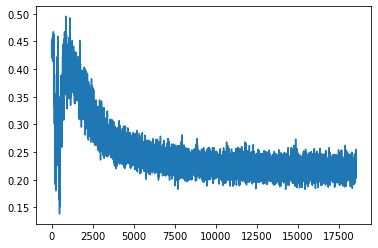

In [13]:
plt.plot(acc_sign)

In [11]:
epochs=1
warmup_steps=2000//(512/64)
# warmup_steps = 100
lr=0.000025
output_dir="./runs"
output_prefix="first"
save_model_on_epoch=True
time_steps = 30
    
device=torch.device("cuda")

batch_size_loader=32
batch_size = 512//batch_size_loader
train_dataloader = DataLoader(dataset, batch_size=batch_size_loader, shuffle=True)
loss=0
accumulating_batch_count = 0
input_tensor = None


optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0)
scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs*train_dataloader.__len__()//batch_size
)


for epoch in range(epochs):

    print(f"Training epoch {epoch}")
        
    pbar = tqdm(enumerate(train_dataloader), total=train_dataloader.__len__())
#     mae_profit = []
    acc = []
    acc_sign = []
    mae = []
#     mae_cash = []
    samples = np.empty((0, 30))
#     cash_preds = np.empty((0, 30))
#     cash_trues = np.empty((0, 30))
#     profit_preds = np.empty((0, 30))
#     profit_trues = np.empty((0, 30))
    input_tensors = torch.empty((0, max_size), dtype=torch.long).cuda()
    for idx, input_tensor in pbar:
        input_tensor = input_tensor.to(device)
#         input_tensors = torch.cat((input_tensors, input_tensor))
        
        if idx == 0 or (accumulating_batch_count % batch_size) == 0:
            output = model.generate(
                input_ids=input_tensor[:, :-time_steps],
                max_length=max_size, temperature=1.0, do_sample=False, top_k=100, seed=42, num_beams=3
            )
            sample = output[:,-time_steps:].cpu().detach().numpy()
            samples = np.concatenate((samples, sample))

            inp = input_tensors[:,-time_steps:].cpu().detach().numpy()
            acc.append((sample == inp).sum()/sample.size)
            acc_sign.append((np.sign(sample-len(clusters)//2) == np.sign(inp-len(clusters)//2)).sum()/sample.size)
            mae.append(mean_absolute_error(inp, sample)/len(clusters))
            

#             profit_pred = clusters[sample]
#             profit_true = clusters[inp]

#             profit_pred = np.sign(profit_pred)*(np.exp(abs(profit_pred)) - 1)
#             profit_true = np.sign(profit_true)*(np.exp(abs(profit_true)) - 1)

#             profit_preds = np.concatenate((profit_preds, profit_pred))
#             profit_trues = np.concatenate((profit_trues, profit_true))

#             mae_profit.append(mean_absolute_error(profit_true, profit_pred))

#             cash_pred = np.ones(profit_pred.shape)
#             cash_true = np.ones(profit_true.shape)
#             for i in range(1, 30):
#                 cash_pred[:,i] = cash_pred[:,i-1]*(1+profit_pred[:,i]/100)
#                 cash_true[:,i] = cash_true[:,i-1]*(1+profit_true[:,i]/100)

#             cash_preds = np.concatenate((cash_preds, cash_pred))
#             cash_trues = np.concatenate((cash_trues, cash_true))

#             mae_cash.append(mean_absolute_error(cash_true-1, cash_pred-1))
        
        outputs = model(input_tensor, labels=input_tensor)
        loss = outputs[0]
        loss.backward()

        if (accumulating_batch_count % batch_size) == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            model.zero_grad()
            
        accumulating_batch_count += 1
        
        input_tensor = None
#         pbar.set_postfix(loss=loss.cpu().detach().numpy(), ACC= acc[-1], mae_profit=mae_profit[-1], mae_cash=mae_cash[-1], 
#                          lr=scheduler.get_last_lr()[0])
        pbar.set_postfix(loss=loss.cpu().detach().numpy(), ACC= acc[-1], ACC_sign= acc_sign[-1], a_mae=mae[-1],
                         lr=scheduler.get_last_lr()[0])
        
    if save_model_on_epoch:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
        )
        
    print(f"Loss: {loss}, ACC: {np.mean(acc)}, ACC_sign: {np.mean(acc_sign)}, MAE: {np.mean(mae)}")
    print()

  0%|                                                                                                                                                                                                           | 0/25489 [00:00<?, ?it/s]

Training epoch 0


c:\program files\python36\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
  0%|                                                                                                                              | 16/25489 [00:13<5:50:00,  1.21it/s, ACC=0.0115, ACC_sign=0.434, a_mae=0.387, loss=4.7863426, lr=1e-7]


RuntimeError: CUDA out of memory. Tried to allocate 5.28 GiB (GPU 0; 24.00 GiB total capacity; 16.35 GiB already allocated; 2.73 GiB free; 19.05 GiB reserved in total by PyTorch)

In [28]:
torch.save(
    model.state_dict(),
    os.path.join(output_dir, f"one_epoch_all_forex.pt"),
)

In [73]:
# del output
# del input_tensors
del input_tensor

NameError: name 'input_tensor' is not defined

In [74]:
# del sample
del samples

In [76]:
del cash_preds 
del cash_trues 
del profit_preds 
del profit_trues 

In [78]:
del pbar

In [80]:
del dataset_test
del test_dataloader

In [81]:
torch.cuda.empty_cache()

In [14]:
data_test = np.load('data/forex/all_forex_data_ffill_test.csv.npy', allow_pickle=True)

In [16]:
data_test_clustered = np.digitize(data_test, clusters, right=False)-1

In [31]:
np.save('data_test_clustered', data_test_clustered)

In [11]:
data_test_clustered = np.load('data_test_clustered.npy')

In [82]:
dataset_test = SongLyrics(data_test_clustered) 
test_dataloader = DataLoader(dataset_test, batch_size=56, shuffle=False)

In [83]:
time_steps = 30
pbar = tqdm(enumerate(test_dataloader), total=test_dataloader.__len__())
mae_profit = []
acc = []
mae_cash = []
samples = np.empty((0, 30))
cash_preds = np.empty((0, 30))
cash_trues = np.empty((0, 30))
profit_preds = np.empty((0, 30))
profit_trues = np.empty((0, 30))
for idx, input_tensor in pbar:
    input_tensor = input_tensor.to(device)
    
    output = model.generate(
        input_ids=input_tensor[:, :-time_steps],
        max_length=max_size, temperature=0.5, do_sample=False, top_k=100, seed=42, num_beams=3, repetition_penalty=0.5
    )
    sample = output[:,-time_steps:].cpu().detach().numpy()
    samples = np.concatenate((samples, sample))
    
    inp = input_tensor[:,-time_steps:].cpu().detach().numpy()
    acc.append((sample == inp).sum()/sample.size)

    profit_pred = clusters[sample]
    profit_true = clusters[inp]

    profit_pred = np.sign(profit_pred)*(np.exp(abs(profit_pred)) - 1)
    profit_true = np.sign(profit_true)*(np.exp(abs(profit_true)) - 1)
    
    profit_preds = np.concatenate((profit_preds, profit_pred))
    profit_trues = np.concatenate((profit_trues, profit_true))

    mae_profit.append(mean_absolute_error(profit_true, profit_pred))

    cash_pred = np.ones(profit_pred.shape)
    cash_true = np.ones(profit_true.shape)
    for i in range(1, 30):
        cash_pred[:,i] = cash_pred[:,i-1]*(1+profit_pred[:,i]/100)
        cash_true[:,i] = cash_true[:,i-1]*(1+profit_true[:,i]/100)
        
    cash_preds = np.concatenate((cash_preds, cash_pred))
    cash_trues = np.concatenate((cash_trues, cash_true))

    mae_cash.append(mean_absolute_error(cash_true-1, cash_pred-1))
#     break

  0%|                                                                                                                                                                                                             | 0/332 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 134.00 MiB (GPU 0; 24.00 GiB total capacity; 20.65 GiB already allocated; 0 bytes free; 22.18 GiB reserved in total by PyTorch)

In [58]:
inp

array([[70, 70, 18, ..., 17, 20, 19],
       [17, 16, 82, ..., 81, 82, 11],
       [18, 24, 80, ..., 78, 81, 19],
       ...,
       [76, 78, 27, ..., 76, 80, 23],
       [20, 15, 18, ..., 21, 23, 79],
       [86, 49, 49, ..., 70, 49, 74]], dtype=int64)

In [61]:
(inp == 49).sum()/inp.size, (samples == 49).sum()/samples.size

(0.06369047619047619, 0.5913095238095238)

In [56]:
model.generate?

In [38]:
acc[-1], mae_profit[-1], mae_cash[-1]

(0.06190476190476191, 0.566537863252662, 0.018833705766187547)

In [40]:
for i in range(1, 30):
    print(mean_absolute_error(cash_trues[:,i]-1, cash_preds[:,i]-1))

0.005327927264014617
0.006650414533385384
0.008242009673536535
0.008732877882193854
0.010007780227318125
0.011146968004746757
0.012357496258328058
0.012808061501812984
0.014038753274218151
0.014923184883101044
0.015632607866635964
0.016322336159430607
0.017123284305053343
0.01825820379885913
0.018967354200362576
0.019197868810065116
0.020285440034510598
0.02023784302688332
0.020653531918031993
0.021012097491917528
0.021937939418352228
0.02218103836111131
0.023333730137836454
0.023147987172615122
0.023595093378702997
0.023786638446498677
0.024526074586196434
0.025315204123370603
0.0254454107844012


In [41]:
cash = 1.0
time_steps = 1
threshold = 0.01
for i in range(cash_preds.shape[0]):
    if cash_preds[i, time_steps] > 1.0 + threshold:
        cash = cash*cash_trues[i,time_steps]
        print(cash, cash_preds[i,time_steps], cash_trues[i,time_steps], profit_preds[i, time_steps], profit_trues[i, time_steps])
    if cash_preds[i, time_steps] < 1.0 - threshold:
        cash = cash*(2-cash_trues[i,time_steps])
        print(cash, cash_preds[i,time_steps], cash_trues[i,time_steps], profit_preds[i, time_steps], profit_trues[i, time_steps])

0.9995249003244331 0.987171967456663 1.000475099675567 -1.282803254333698 0.04750996755668879
1.0123468382736707 0.9828171817154095 0.987171967456663 -1.718281828459045 -1.282803254333698
1.0170730008791997 0.987171967456663 0.9953314788698423 -1.282803254333698 -0.4668521130157741
1.017661330120389 0.987171967456663 0.9994215466926359 -1.282803254333698 -0.05784533073640663
1.0253423955969467 1.012828032543337 1.0075477619608963 1.282803254333698 0.7547761960896255
1.0240217818563366 0.987171967456663 1.001287973408962 -1.282803254333698 0.12879734089618688
1.0162927092041123 1.012828032543337 0.9924522380391038 1.282803254333698 -0.7547761960896255
0.9988299362579041 0.9828171817154095 1.0171828182845903 -1.718281828459045 1.718281828459045
0.9860169133303285 1.012828032543337 0.987171967456663 1.282803254333698 -1.282803254333698
1.0029594627776162 1.012828032543337 1.0171828182845903 1.282803254333698 1.718281828459045
1.0023792975592203 0.9828171817154095 1.000578453307364 -1.7182

In [46]:
cash_preds[10]

array([1.        , 0.99628057, 0.99925196, 0.99553532, 0.99850448,
       0.99479062, 0.99775756, 0.99404647, 0.9970112 , 0.99330289,
       0.99626539, 0.99255986, 0.99552015, 0.99181738, 0.99477546,
       0.99107547, 0.99403133, 0.9903341 , 0.99328775, 0.98959329,
       0.99254474, 0.98885304, 0.99180227, 0.98811334, 0.99106037,
       0.98737419, 0.99031901, 0.9866356 , 0.98957822, 0.98589755])